# Train size

Imagine that we have only a few clients for CoLES pretrain. Let's try a different sizes.

We will keep the same amount of clients for downstream task train.

Small pretrain data may be a cause of network overfit. Let's try a different rnn hidden sizes.

Keep in mind than agg baseline don't require any data for pretrain.


In [1]:
import pickle

import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from ptls.preprocessing import PandasDataPreprocessor

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
from glob import glob

In [5]:
import ptls.data_load
import ptls.data_load.datasets
import ptls.frames
import ptls.frames.coles
import ptls.frames.inference_module
import ptls.nn

In [6]:
import torch

In [7]:
from functools import partial

In [8]:
import pytorch_lightning as pl

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [10]:
import datetime

In [11]:
def get_norm(df):
    values = torch.cat(list(rec['amount_rur'] for rec in df))
    values = values.sign() * values.abs().log1p()
    m = values.mean().item()
    s = values.std().item()
    return m, s

In [12]:
class LogScaler(ptls.nn.trx_encoder.scalers.IdentityScaler):
    def __init__(self, m, s):
        super().__init__()
        self.m = m
        self.s = s
        
    def forward(self, x):
        x = super().forward(x)
        return (x.abs().log1p() * x.sign() - self.m) / self.s

    @property
    def output_size(self):
        return 1

In [13]:
params = [
    (fold_i, train_size, max_steps, hidden_size)
    for fold_i in [2, 3, 4]
    for train_size in [1200]
    for hidden_size in [800]
    # for train_size in [1200, 2500, 5000, 10000, 20000, 40000]
    for max_steps in [100000]
]

In [ ]:
MODEL_NAME='04_coles_train_size'

for fold_i, train_size, max_steps, hidden_size in params:

    df_trx_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_trx_pretrain.pickle')
    df_seq_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_seq_pretrain.pickle')
    df_gbm_train = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_train.pickle')
    df_gbm_test = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_test.pickle')

    with open(f'data/fold_{fold_i}/pdp.pickle', 'rb') as f:
        pdp = pickle.load(f)

    df_seq_pretrain_train, df_seq_pretrain_valid = train_test_split(
        df_seq_pretrain, test_size=0.05, shuffle=True, random_state=42)

    full_train = df_seq_pretrain_train.to_dict(orient='records') +\
    df_trx_pretrain.to_dict(orient='records')
    
    coles_data_module = ptls.frames.PtlsDataModule(
        train_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                full_train[:train_size] * int(40000 / train_size)
            ),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=200,
            ),
        ),
        valid_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                df_seq_pretrain_train.to_dict(orient='records')),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=100,
            ),
        ),
        train_batch_size=64,
        train_num_workers=4,
        valid_batch_size=650,
    )

    pl_coles_module = ptls.frames.coles.CoLESModule(
        validation_metric=ptls.frames.coles.metric.BatchRecallTopK(
            K=4,
            metric='cosine',
        ),
        seq_encoder=torch.nn.Sequential(
            ptls.nn.TrxEncoder(
                norm_embeddings=False,
                embeddings_noise=0.003,
                use_batch_norm=False,
                embeddings={
                    'weekday': {'in': 10, 'out': 8},
                    'small_group': {'in': 250, 'out': 16},
                    'event_time': {'in': 800, 'out': 8},
                },
                numeric_values={ 
                    # 'amount_rur': 'identity',
                    # 'amount_rur': 'log',
                    'amount_rur': LogScaler(*get_norm(full_train[:train_size])),
                },
            ),
            ptls.nn.RnnEncoder(
                # input_size=25,
                input_size=33,
                type='gru',
                hidden_size=hidden_size,
                is_reduce_sequence=True,
            ),
        ),
        head=ptls.nn.Head(use_norm_encoder=True),
        loss=ptls.frames.coles.losses.ContrastiveLoss(
            margin=0.5,
            sampling_strategy=ptls.frames.coles.sampling_strategies.HardNegativePairSelector(
              neg_count=5,
            ),
        ),
        # loss=ptls.frames.coles.losses.SoftmaxLoss(
        #     temperature=0.05,
        # ),
        optimizer_partial=partial(torch.optim.Adam, lr=0.001, weight_decay=0.0),
        lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9025)
    )

    model_checkpoint = pl.callbacks.ModelCheckpoint(
        save_top_k=-1, 
        save_weights_only=True, 
        every_n_train_steps=5000,
    )
    
    trainer = pl.Trainer(
        gpus=1,
        max_steps=max_steps,
        check_val_every_n_epoch=3,
        max_epochs=20000, # 150,
        # enable_checkpointing=False,
        enable_progress_bar=False,
        gradient_clip_val=0.5,
        gradient_clip_algorithm="value",
        callbacks=[
            model_checkpoint,
        ],
    )   

    pretrain_logger_version = trainer.logger.version
    print(f'pretrain_logger_version = {pretrain_logger_version}')
    trainer.fit(pl_coles_module, coles_data_module)

    for train_steps in [
        5000, 10000, 15000, 25000, 50000, 75000, 100000,
        20000, 30000, 40000, 60000, 70000, 80000, 90000,
    ]:
        ckpt_path = glob(model_checkpoint.dirpath + f'/*-step={train_steps}.ckpt')[0]
        pl_coles_module.load_state_dict(torch.load(ckpt_path)['state_dict'])
        
        inference_dl_gbm_train = torch.utils.data.DataLoader(
            dataset=ptls.data_load.datasets.MemoryMapDataset(
                df_gbm_train.to_dict(orient='records'),
                i_filters=[
                    ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
                ],
            ),
            collate_fn=ptls.data_load.utils.collate_feature_dict,
            shuffle=False,
            batch_size=1000,
            num_workers=12,
        )

        inference_dl_gbm_test = torch.utils.data.DataLoader(
            dataset=ptls.data_load.datasets.MemoryMapDataset(
                df_gbm_test.to_dict(orient='records'),
                i_filters=[
                    ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
                ],
            ),
            collate_fn=ptls.data_load.utils.collate_feature_dict,
            shuffle=False,
            batch_size=1000,
            num_workers=12,
        )

        inf_model = ptls.frames.inference_module.InferenceModule(
            model=pl_coles_module.seq_encoder, pandas_output=True, model_out_name='emb')

        predict_gbm_train = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
        .predict(inf_model, inference_dl_gbm_train)

        predict_gbm_test = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
        .predict(inf_model, inference_dl_gbm_test)

        predict_gbm_train = pd.concat(predict_gbm_train, axis=0)

        predict_gbm_test = pd.concat(predict_gbm_test, axis=0)

        predict_gbm_train.set_index('client_id', inplace=True)
        predict_gbm_test.set_index('client_id', inplace=True)

        gbm_model = LGBMClassifier(**{
              'n_estimators': 1000,
              'boosting_type': 'gbdt',
              'objective': 'multiclass',
              'num_class': 4,
              'metric': 'multi_error',
              'learning_rate': 0.02,
              'subsample': 0.75,
              'subsample_freq': 1,
              'feature_fraction': 0.75,
              'colsample_bytree': None,
              'max_depth': 12,
              'lambda_l1': 1,
              'reg_alpha': None,
              'lambda_l2': 1,
              'reg_lambda': None,
              'min_data_in_leaf': 50,
              'min_child_samples': None,
              'num_leaves': 50,
              'random_state': 42,
              'n_jobs': 4,
        })

        gbm_model.fit(predict_gbm_train.drop(columns='bins'), predict_gbm_train['bins'])

        acc = accuracy_score(
            gbm_model.predict(predict_gbm_test.drop(columns='bins')), 
            predict_gbm_test['bins'],
        )
        acc

        with open('results-train-size.log', 'at') as f:
            print('\t'.join([
                MODEL_NAME,
                f'{datetime.datetime.now():%Y-%m-%d %H:%M:%S}',
                f'{fold_i}',
                'accuracy',
                f'{acc:.4f}',
                f'{pretrain_logger_version}',
                f'{train_size}',
                f'{train_steps}',
                f'{hidden_size}',
        ]), file=f)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


pretrain_logger_version = 181


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | Sequential      | 2.0 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.061     Total estimated model params size (MB)


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ptls.tb_interface import get_scalars

In [17]:
df_res = pd.read_csv(
    # 'results.log',
    'results-train-size.log',
    sep='\t', header=None,
    names=['model', 'time', 'fold_i', 'metric', 'value',
           'pretrain_logger_version', 'train_size', 'train_steps', 'hidden_size']
)
df_res.tail(10)

model                 time  fold_i    metric   value  \
2510  04_coles_train_size  2024-02-08 07:34:01       4  accuracy  0.6020   
2511  04_coles_train_size  2024-02-08 07:40:14       4  accuracy  0.6027   
2512  04_coles_train_size  2024-02-08 07:46:33       4  accuracy  0.5950   
2513  04_coles_train_size  2024-02-08 07:52:51       4  accuracy  0.6030   
2514  04_coles_train_size  2024-02-08 07:59:11       4  accuracy  0.6003   
2515  04_coles_train_size  2024-02-08 08:05:28       4  accuracy  0.5983   
2516  04_coles_train_size  2024-02-08 08:11:42       4  accuracy  0.6080   
2517  04_coles_train_size  2024-02-08 08:18:02       4  accuracy  0.6007   
2518  04_coles_train_size  2024-02-08 08:24:22       4  accuracy  0.6028   
2519  04_coles_train_size  2024-02-08 08:30:40       4  accuracy  0.6102   

      pretrain_logger_version  train_size  train_steps  hidden_size  
2510                      183        1200        50000          800  
2511                      183        1200        75000          800  
2512                      183        1200       100000          800  
2513                      183        1200        20000          800  
2514                      183        1200        30000          800  
2515                      183        1200        40000          800  
2516                      183        1200        60000          800  
2517                      183        1200        70000          800  
2518                      183        1200        80000          800  
2519                      183        1200        90000          800

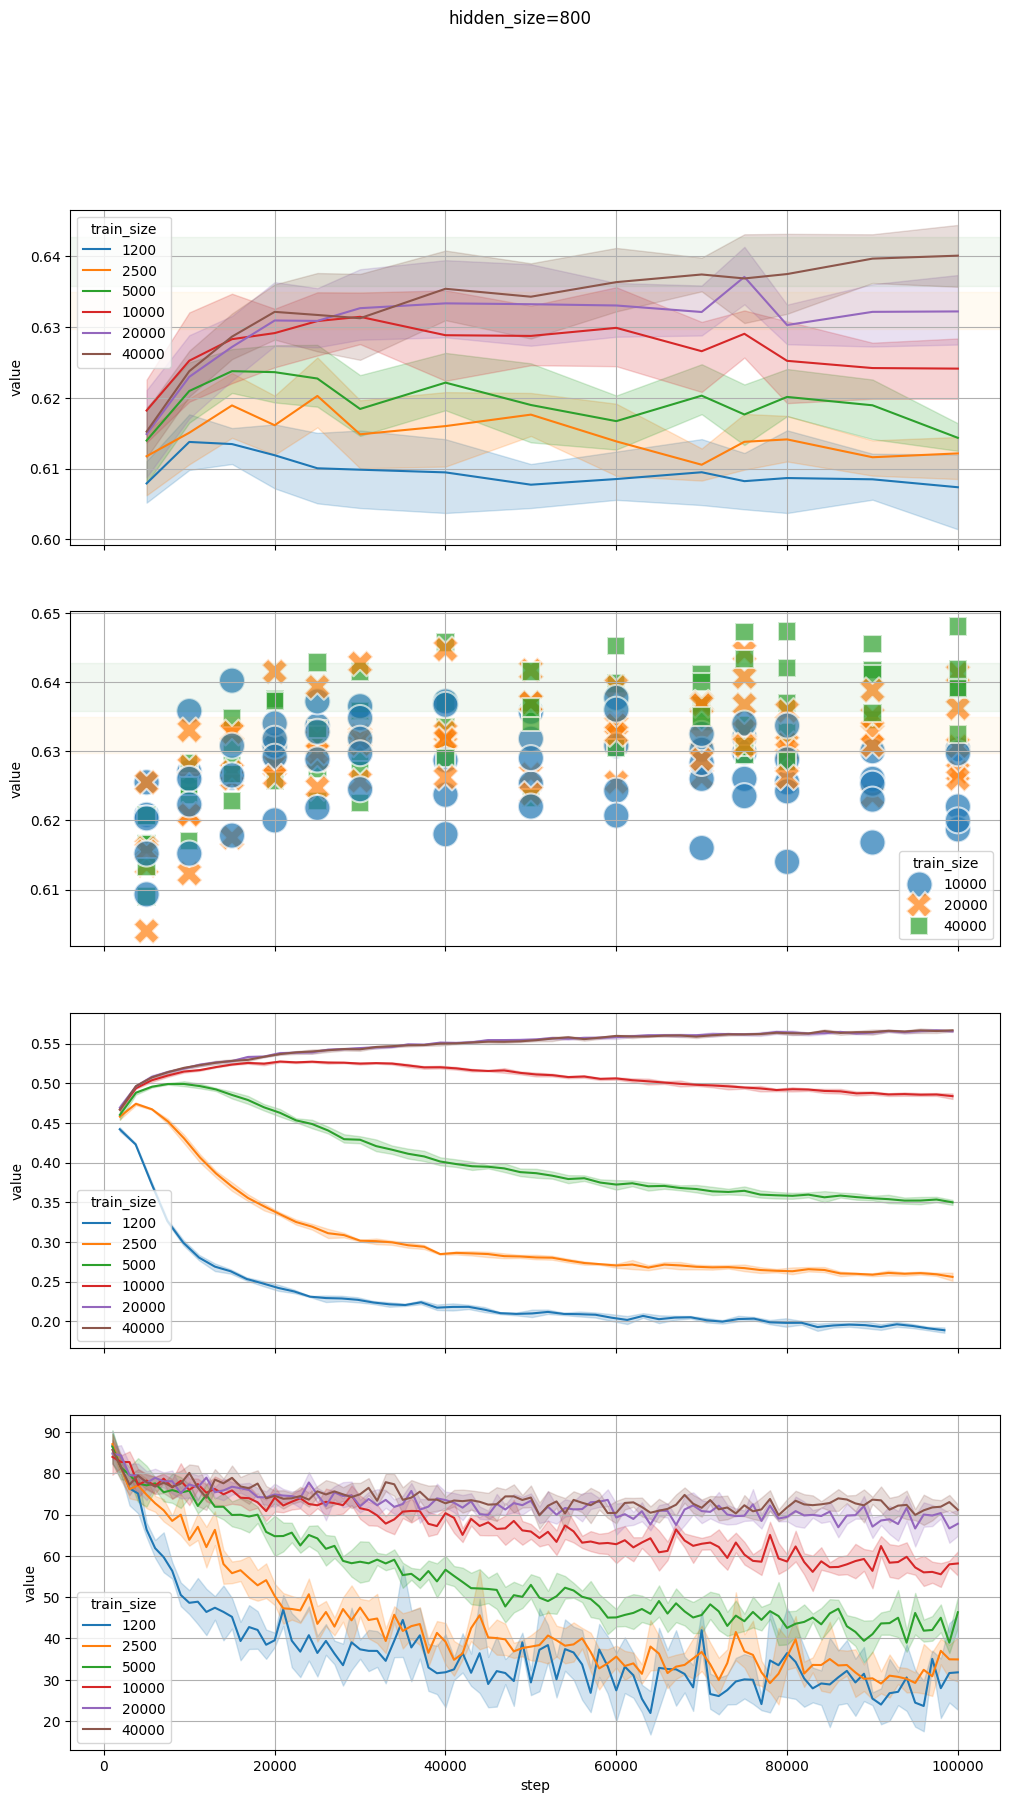

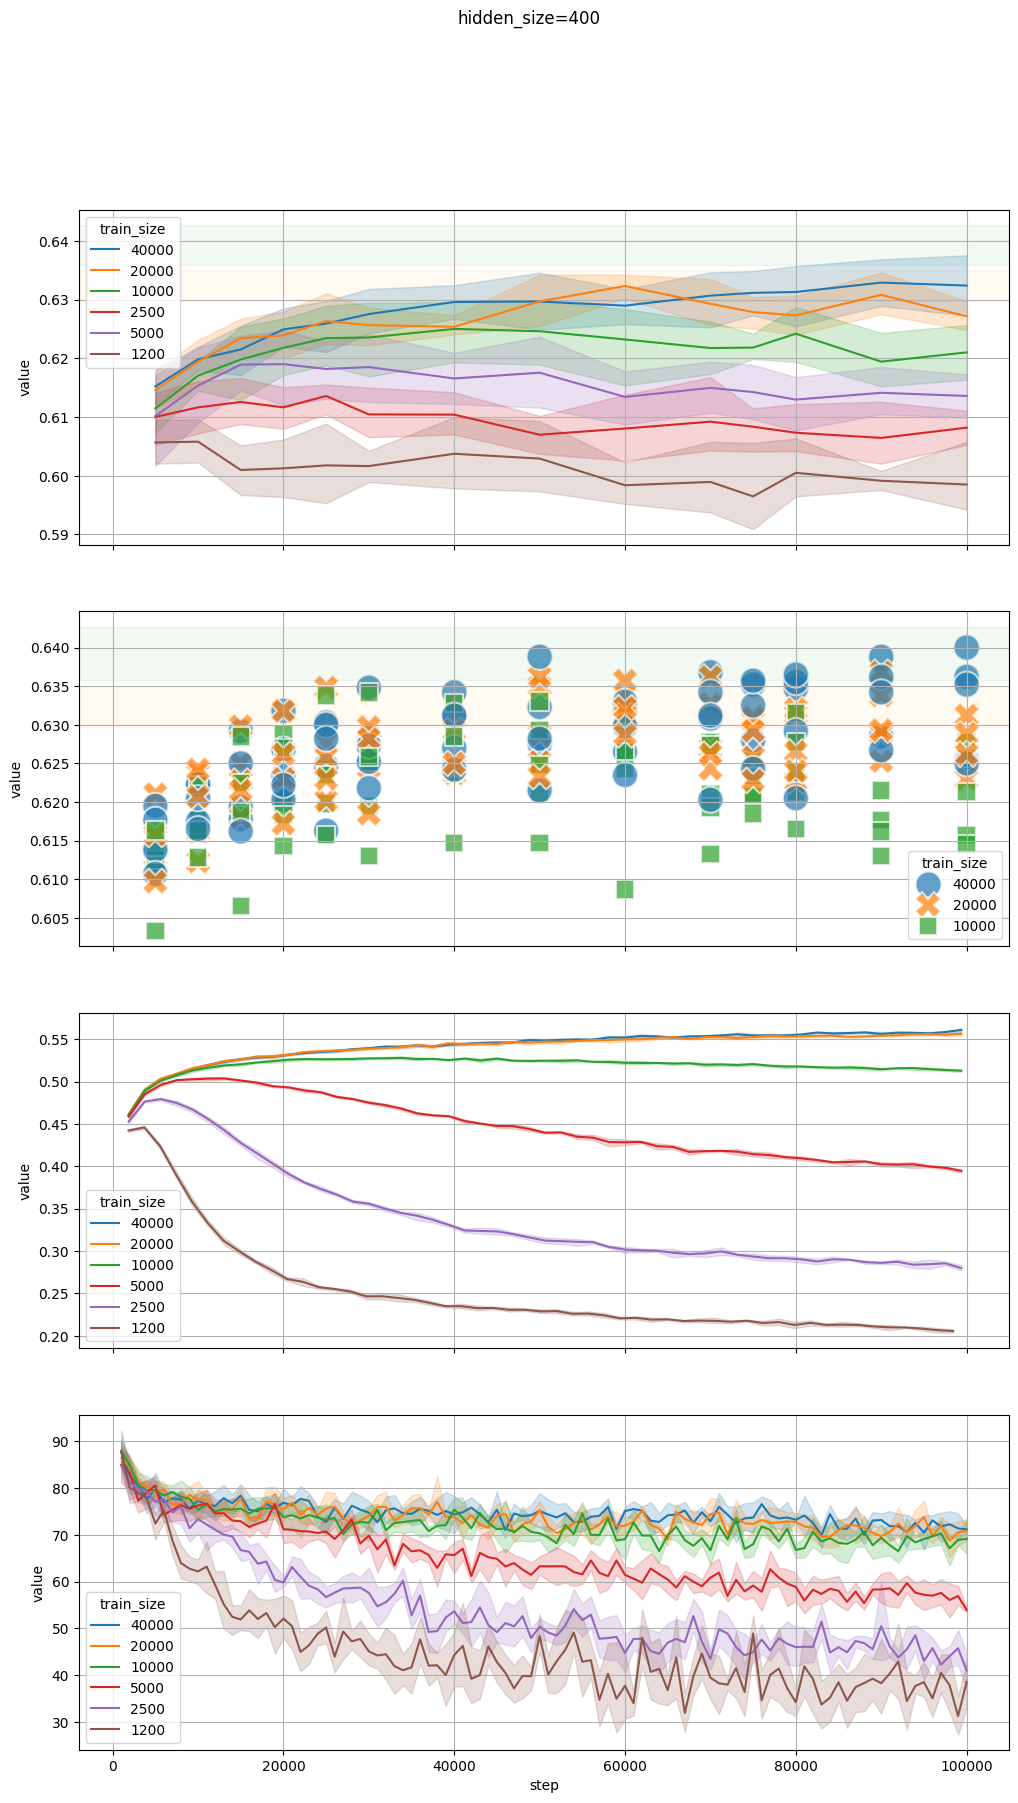

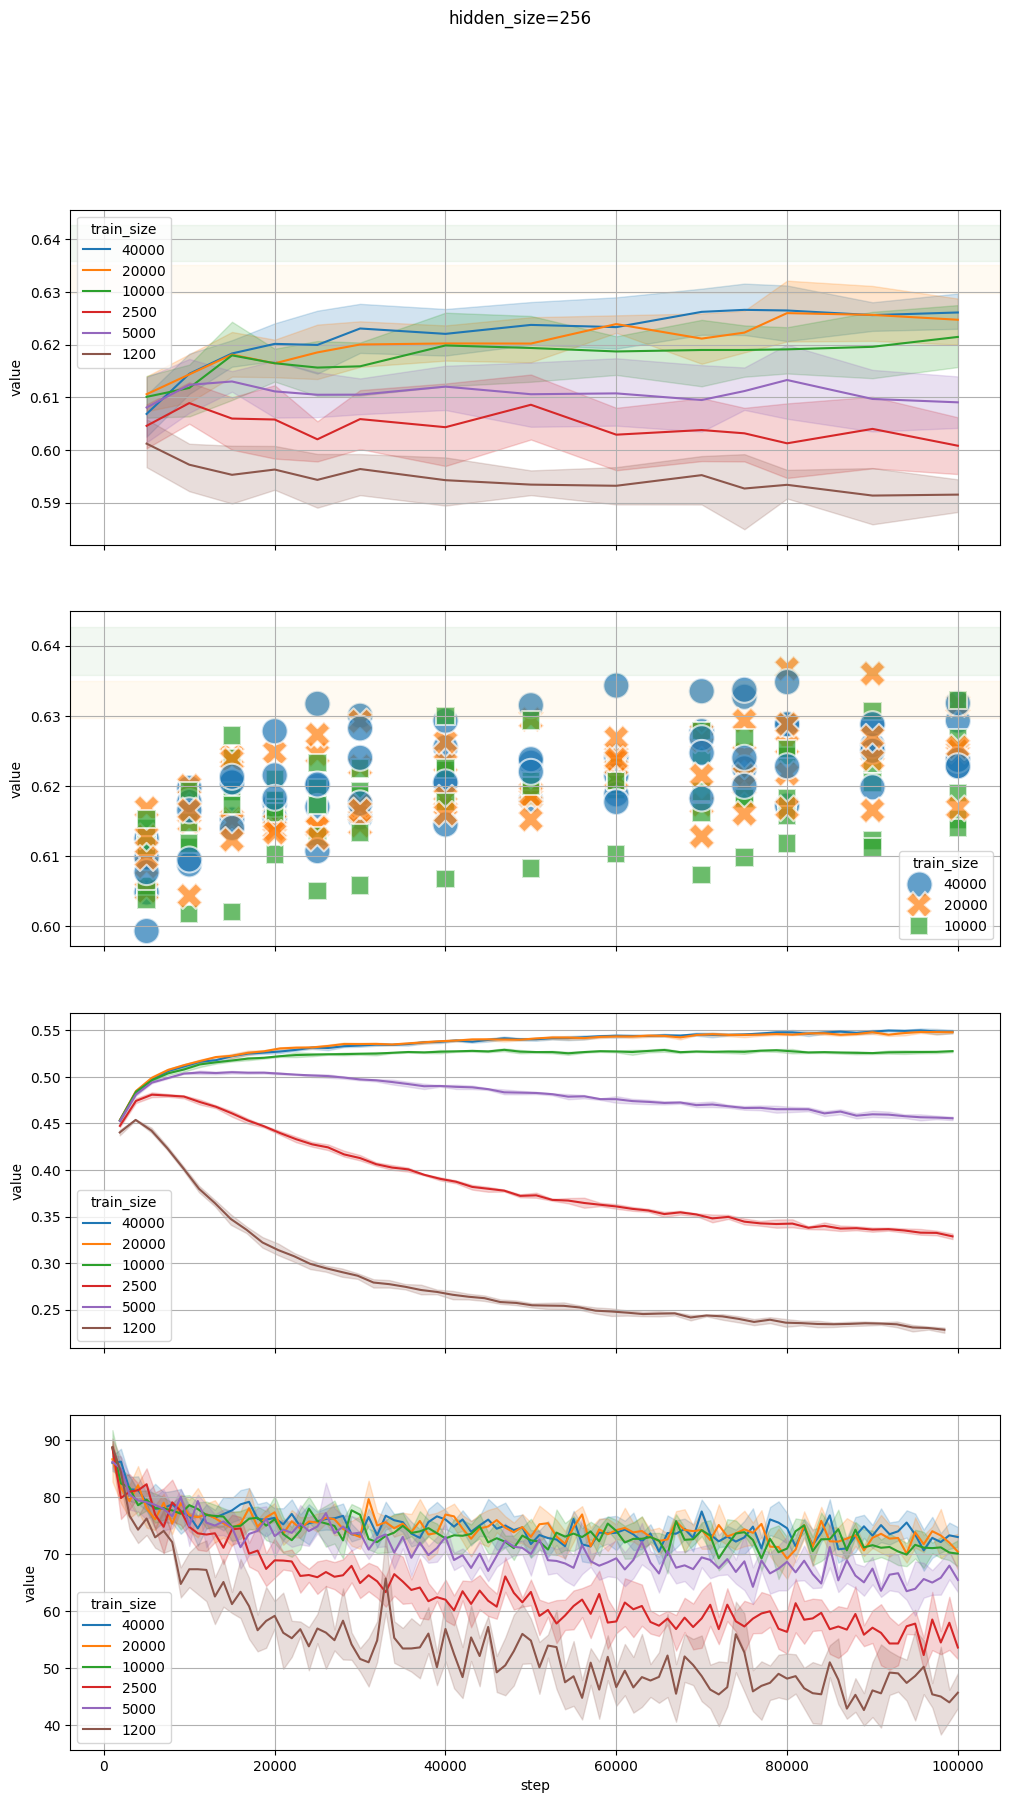

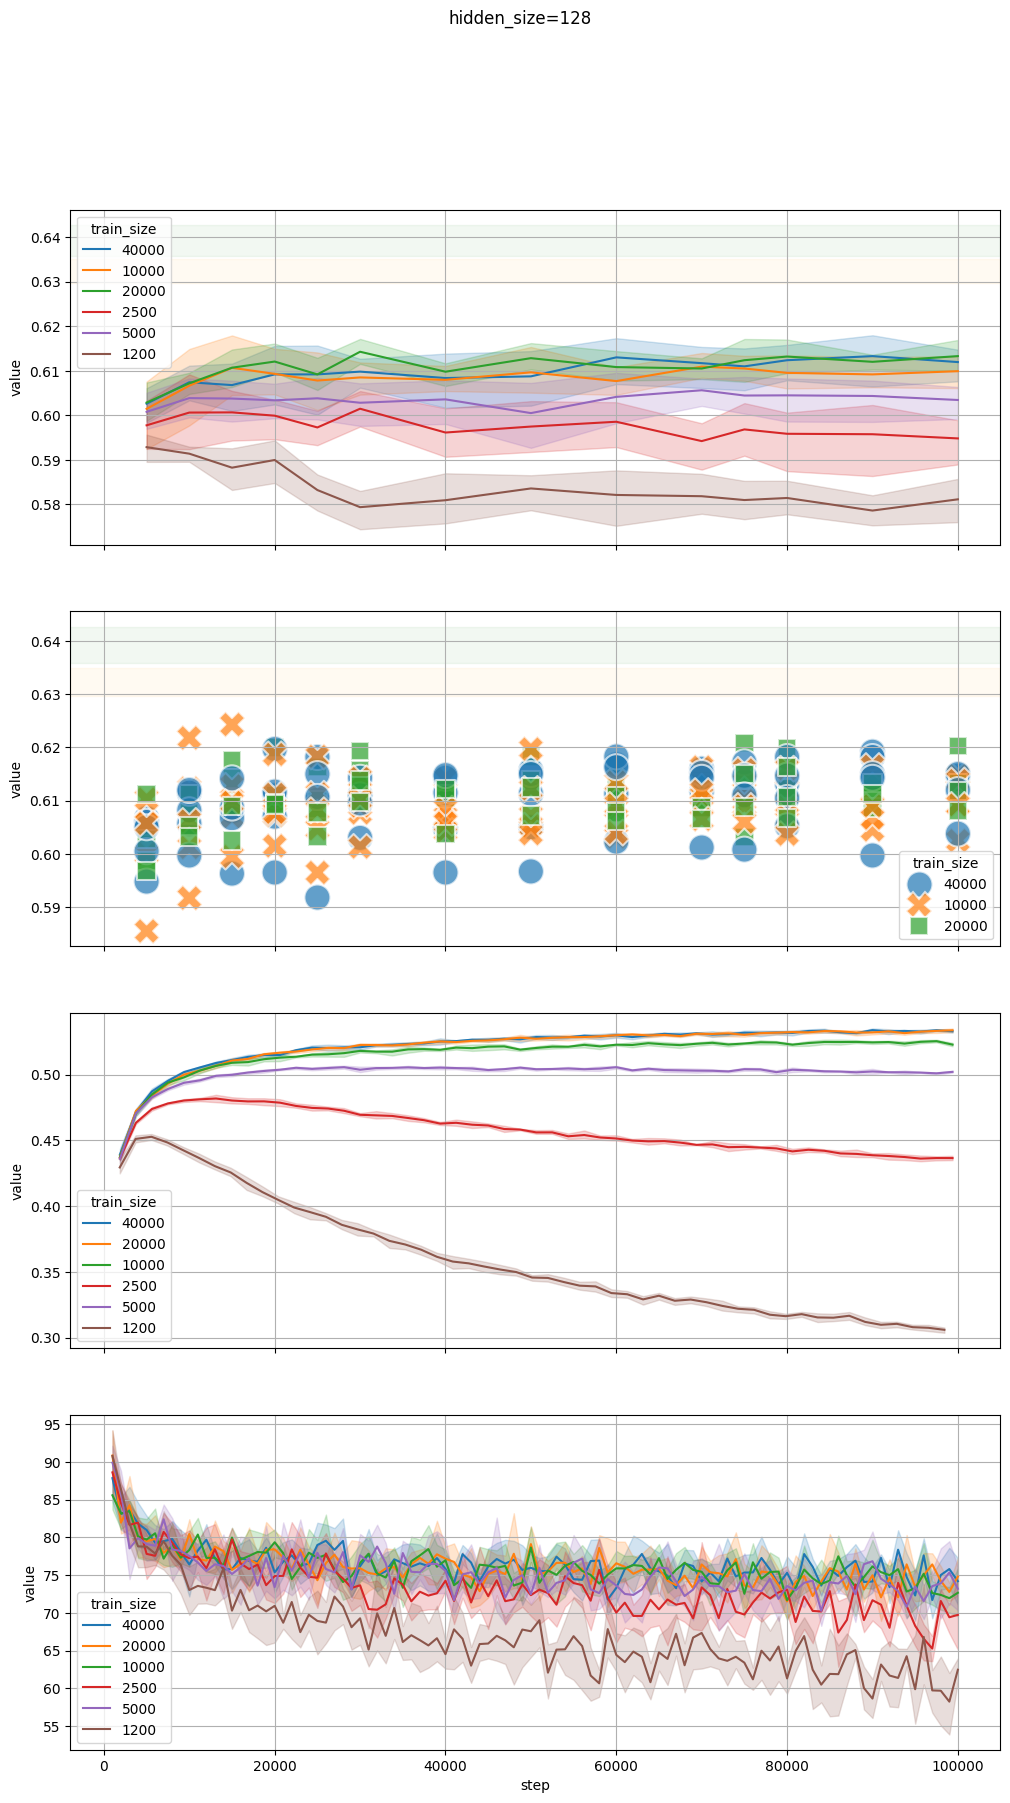

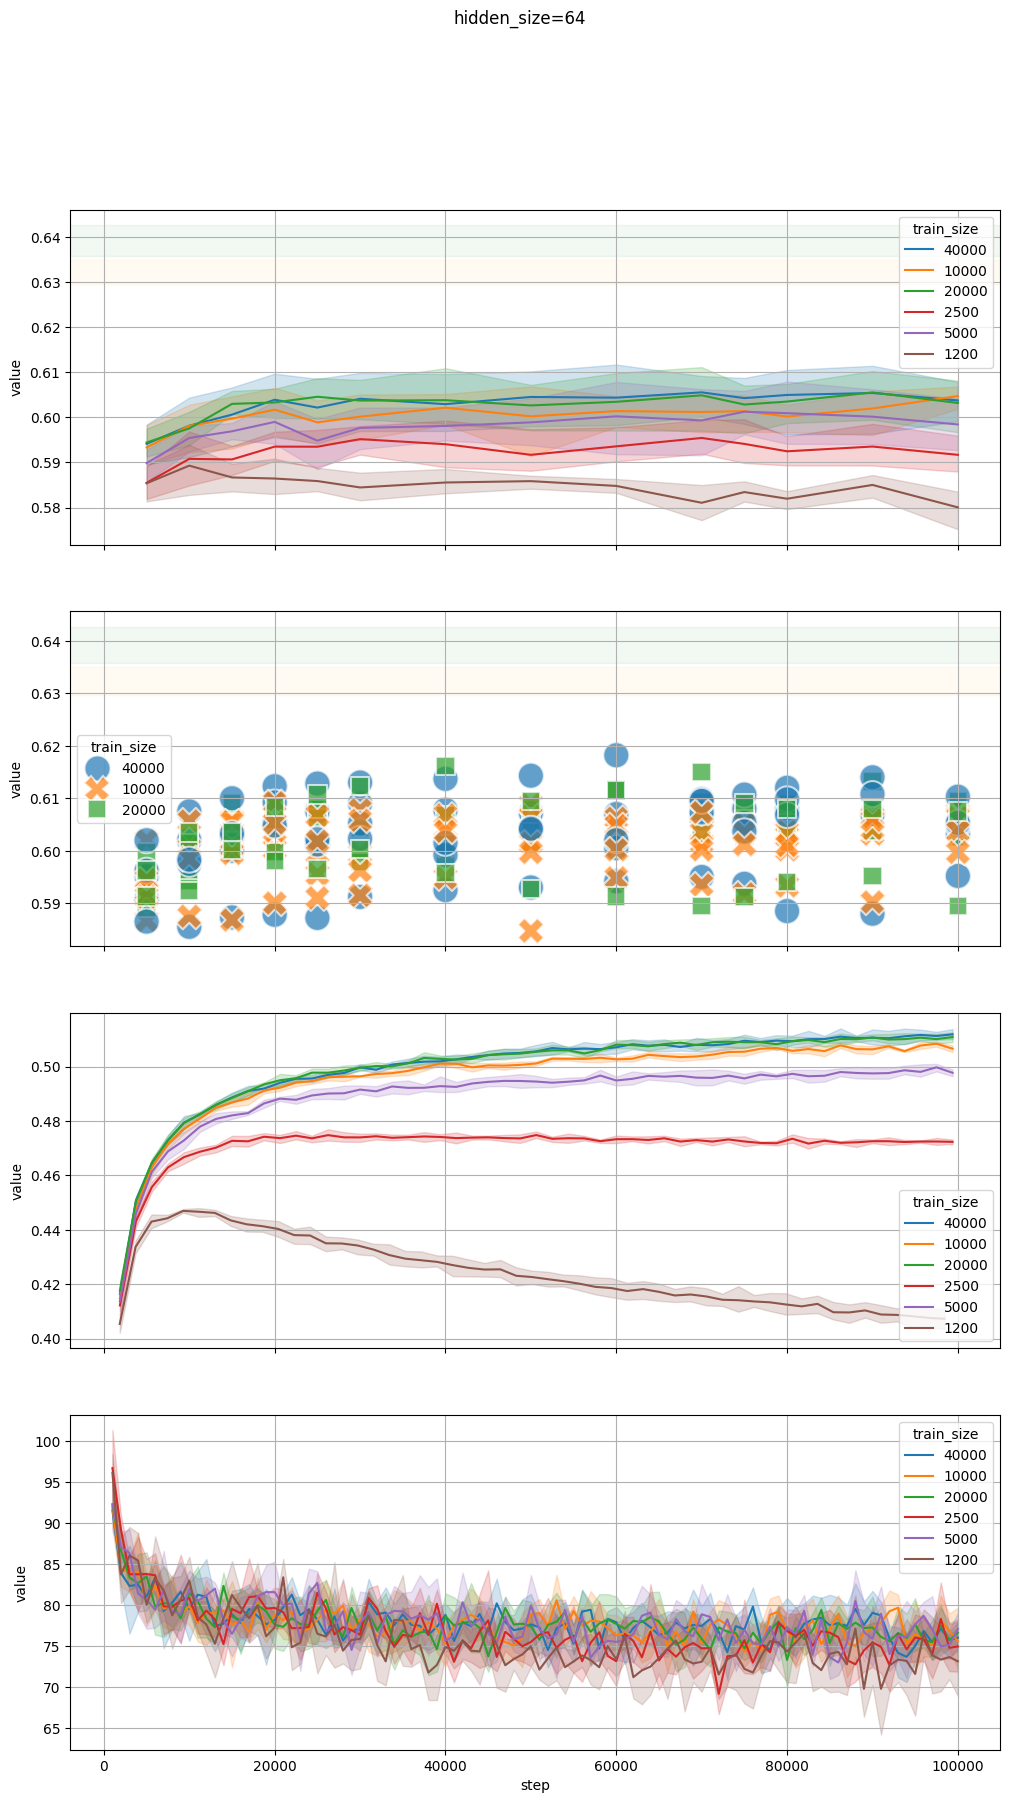

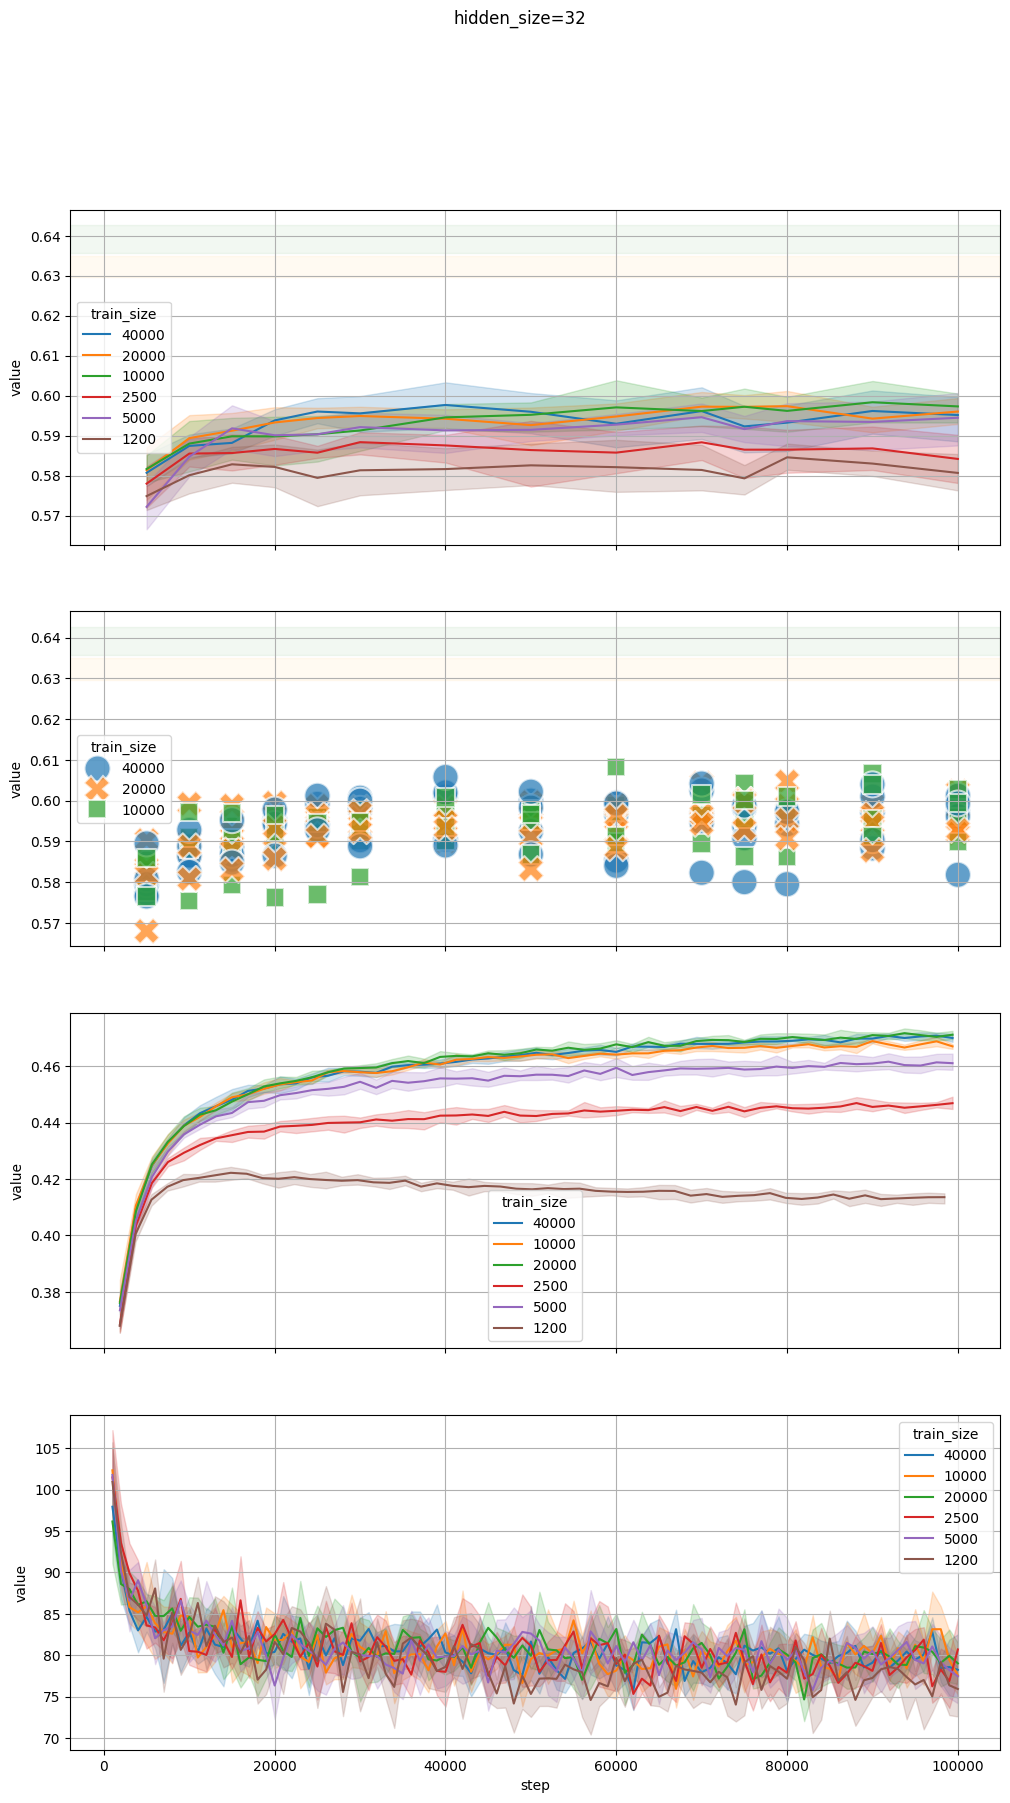

In [19]:
df_tb = get_scalars('lightning_logs/')
df_tb = df_tb[lambda x: 
              x['tag'].eq('valid/recall_top_k') | 
              x['tag'].eq('loss') & ((x['step'] + 1) % 1000 == 0)]
    
for hidden_size in df_res['hidden_size'].unique():
    _, axs = plt.subplots(4, 1, figsize=(12, 5 * 4), sharex=True)
    sns.lineplot(
        data=df_res[lambda x: x['hidden_size'].eq(hidden_size)]
        .assign(train_size=lambda x: x['train_size'].astype(str)),
        x='train_steps',
        y='value',
        hue='train_size',# palette=plt.get_cmap('tab10'),
        ax=axs[0],
    )
    sns.scatterplot(
        data=df_res
        [lambda x: x['hidden_size'].eq(hidden_size)]
        [lambda x: x['train_size'].ge(10000)]
        .assign(train_size=lambda x: x['train_size'].astype(str)),
        x='train_steps',
        y='value',
        # marker="d",
        hue='train_size', #palette=plt.get_cmap('tab10'),
        style='train_size',
        # c='k',
        s=350, alpha=0.7,
        ax=axs[1],
    )
    for ax in axs[:2]:
        ax.axhspan(ymin=0.6297, ymax=0.6350, alpha=0.05, color='orange')
        ax.axhspan(ymin=0.6358, ymax=0.6427, alpha=0.05, color='green')
        # ax.axhspan(ymin=0.3845, ymax=0.3872, alpha=0.1, color='red')

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['hidden_size'].eq(hidden_size)]
            .groupby('pretrain_logger_version', as_index=False)['train_size'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'train_size']],
            df_tb[lambda x: x['tag'].eq('valid/recall_top_k')],
            on='version',
        ).assign(train_size=lambda x: x['train_size'].astype(str)),
        x='step',
        y='value',
        hue='train_size',# palette=plt.get_cmap('tab10'),
        ax=axs[2],
    )

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['hidden_size'].eq(hidden_size)]
            .groupby('pretrain_logger_version', as_index=False)['train_size'].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'train_size']],
            df_tb[lambda x: x['tag'].eq('loss')],  # [lambda x: (x['step'] + 1) % 1000 == 0]
            on='version',
        ).assign(train_size=lambda x: x['train_size'].astype(str)),
        x='step',
        y='value',
        hue='train_size',# palette=plt.get_cmap('tab10'),
        ax=axs[3],
    )
    for ax in axs:
        ax.grid()
        
    plt.suptitle(f'hidden_size={hidden_size}')
    plt.show()


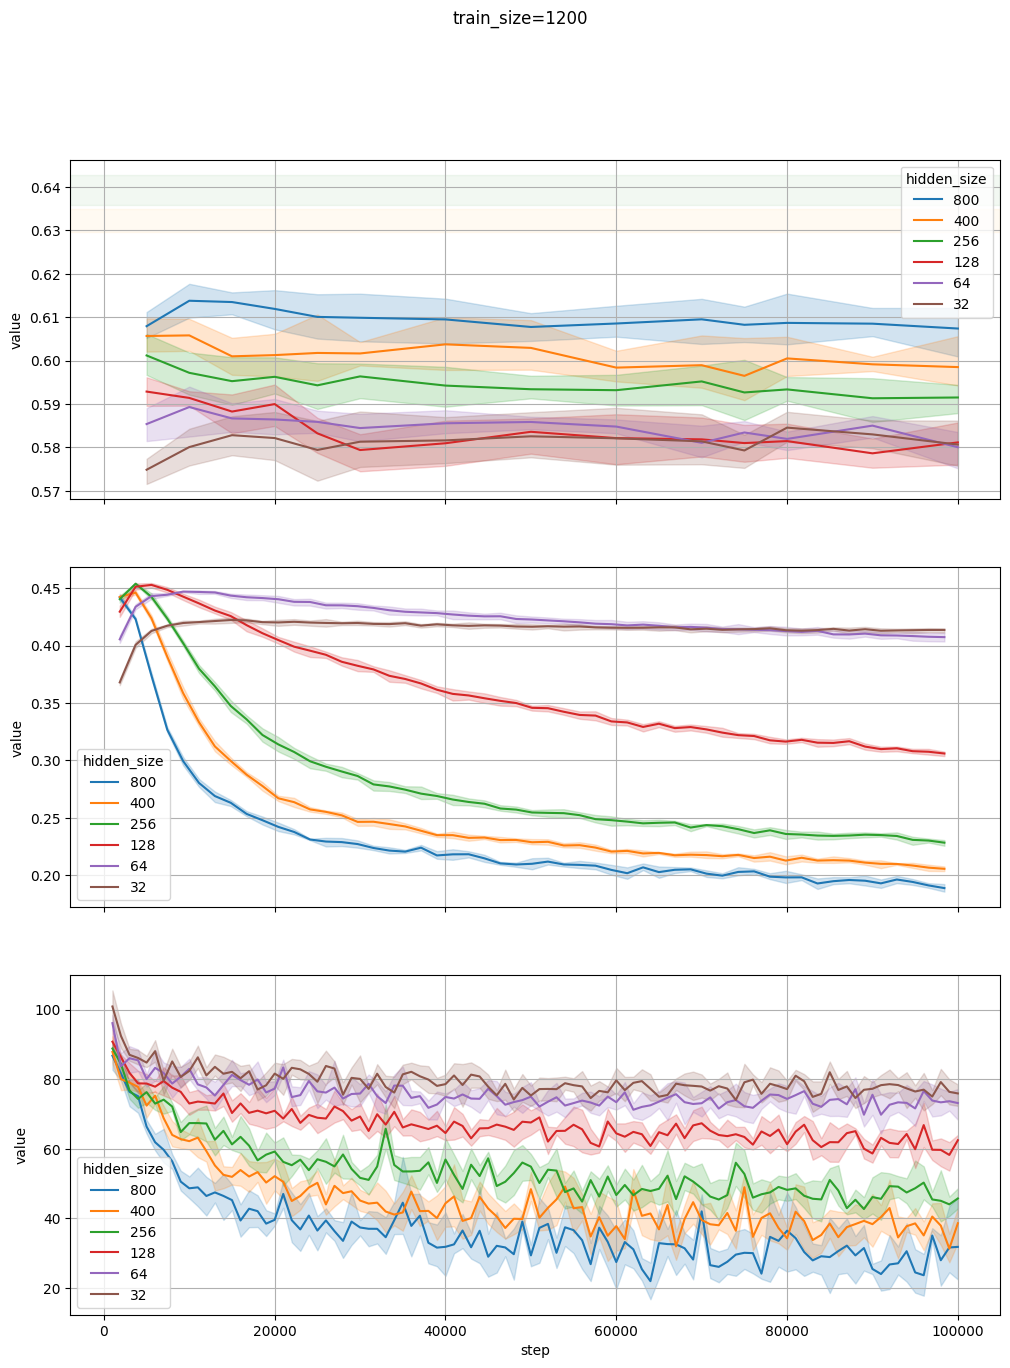

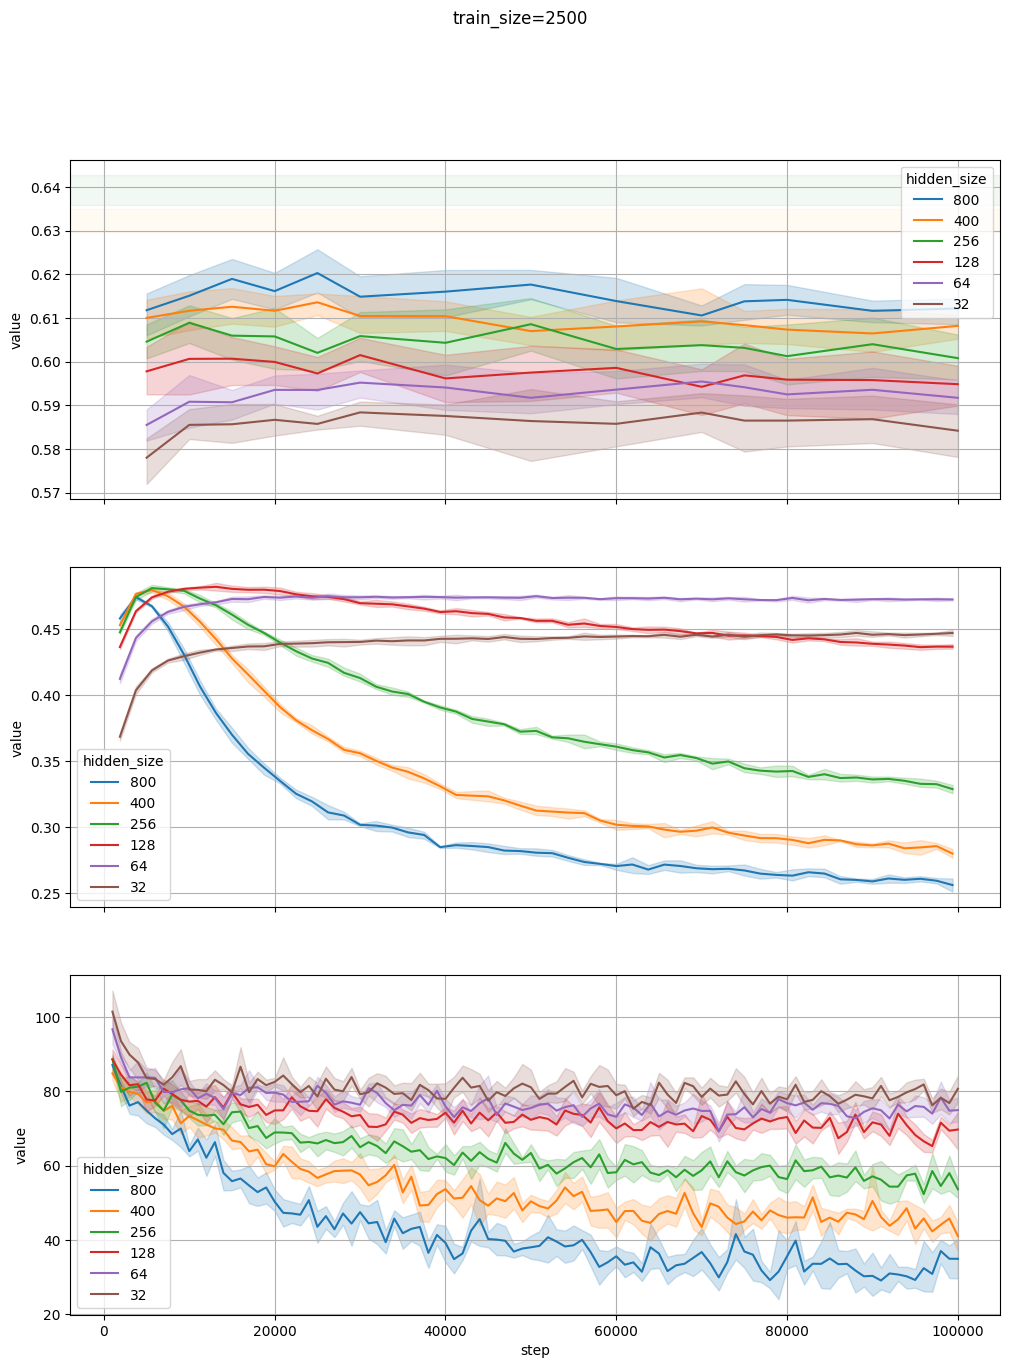

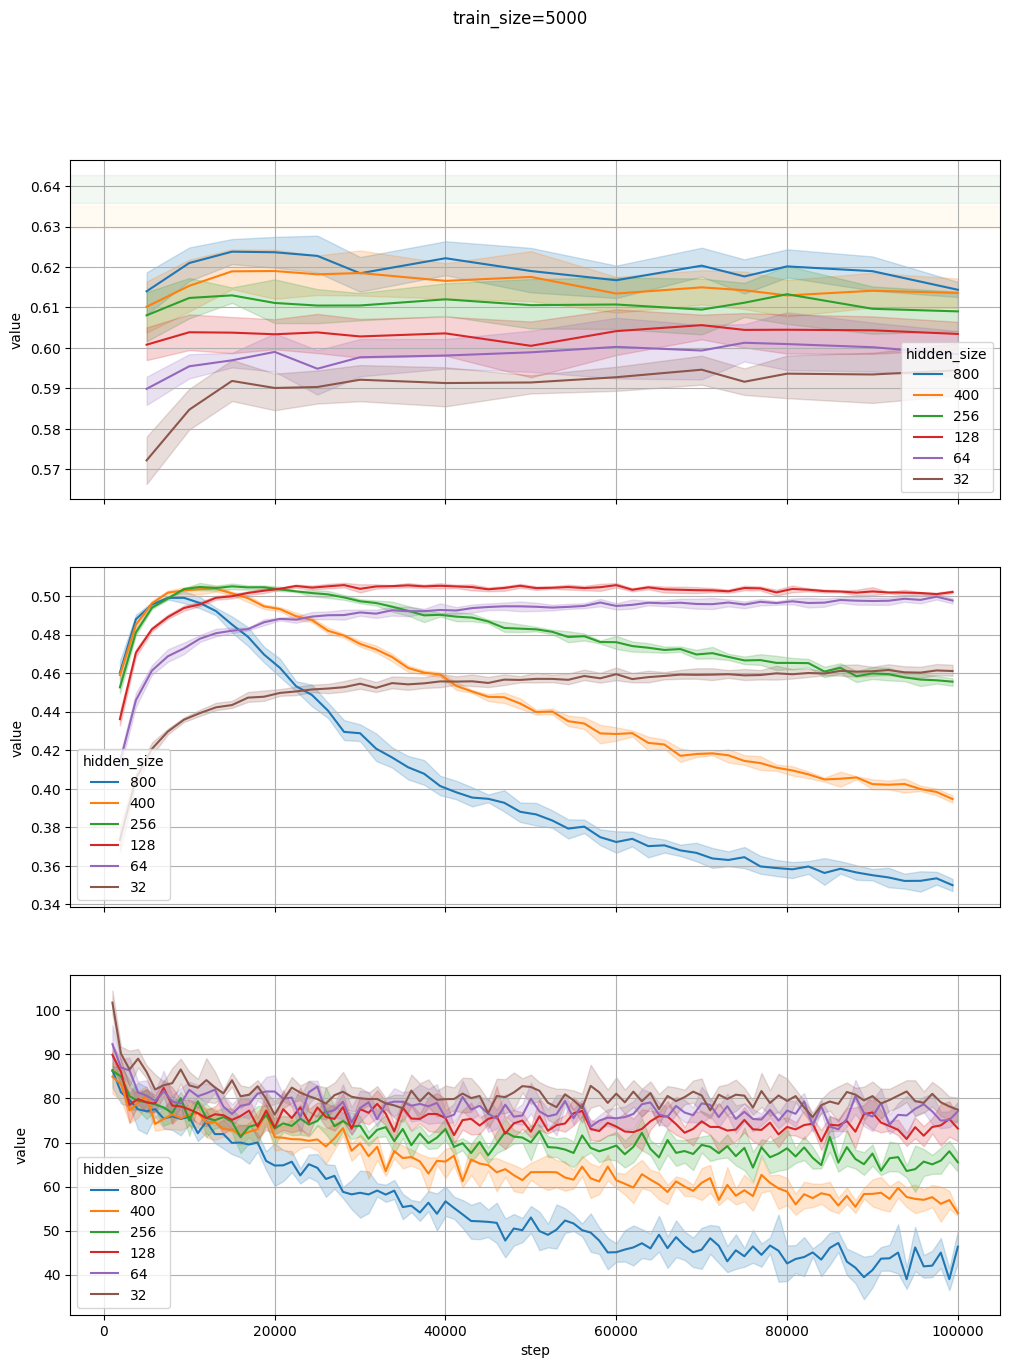

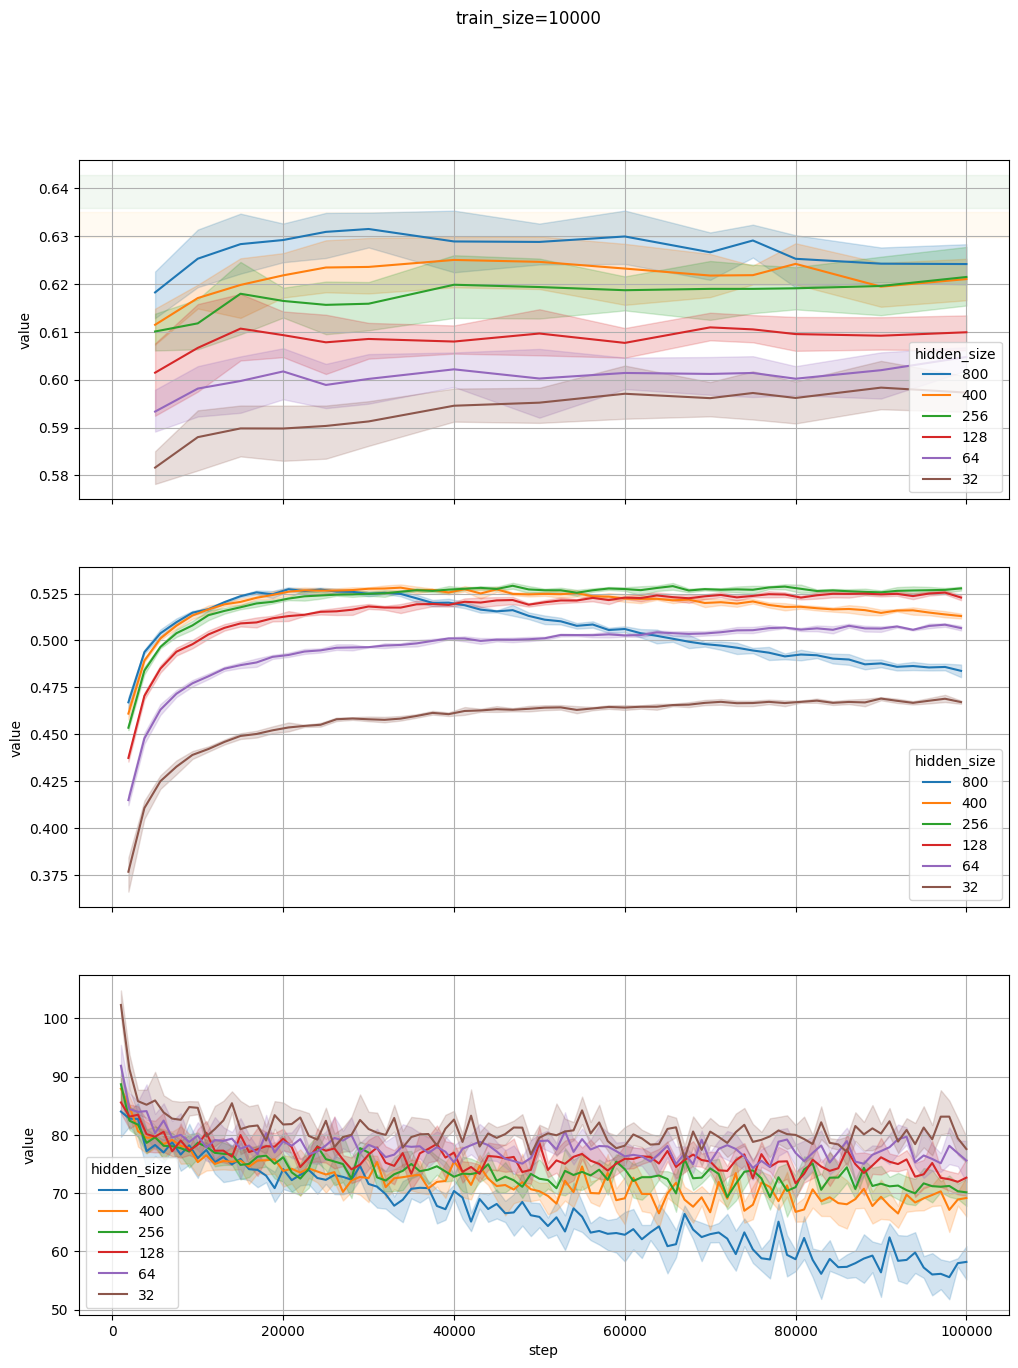

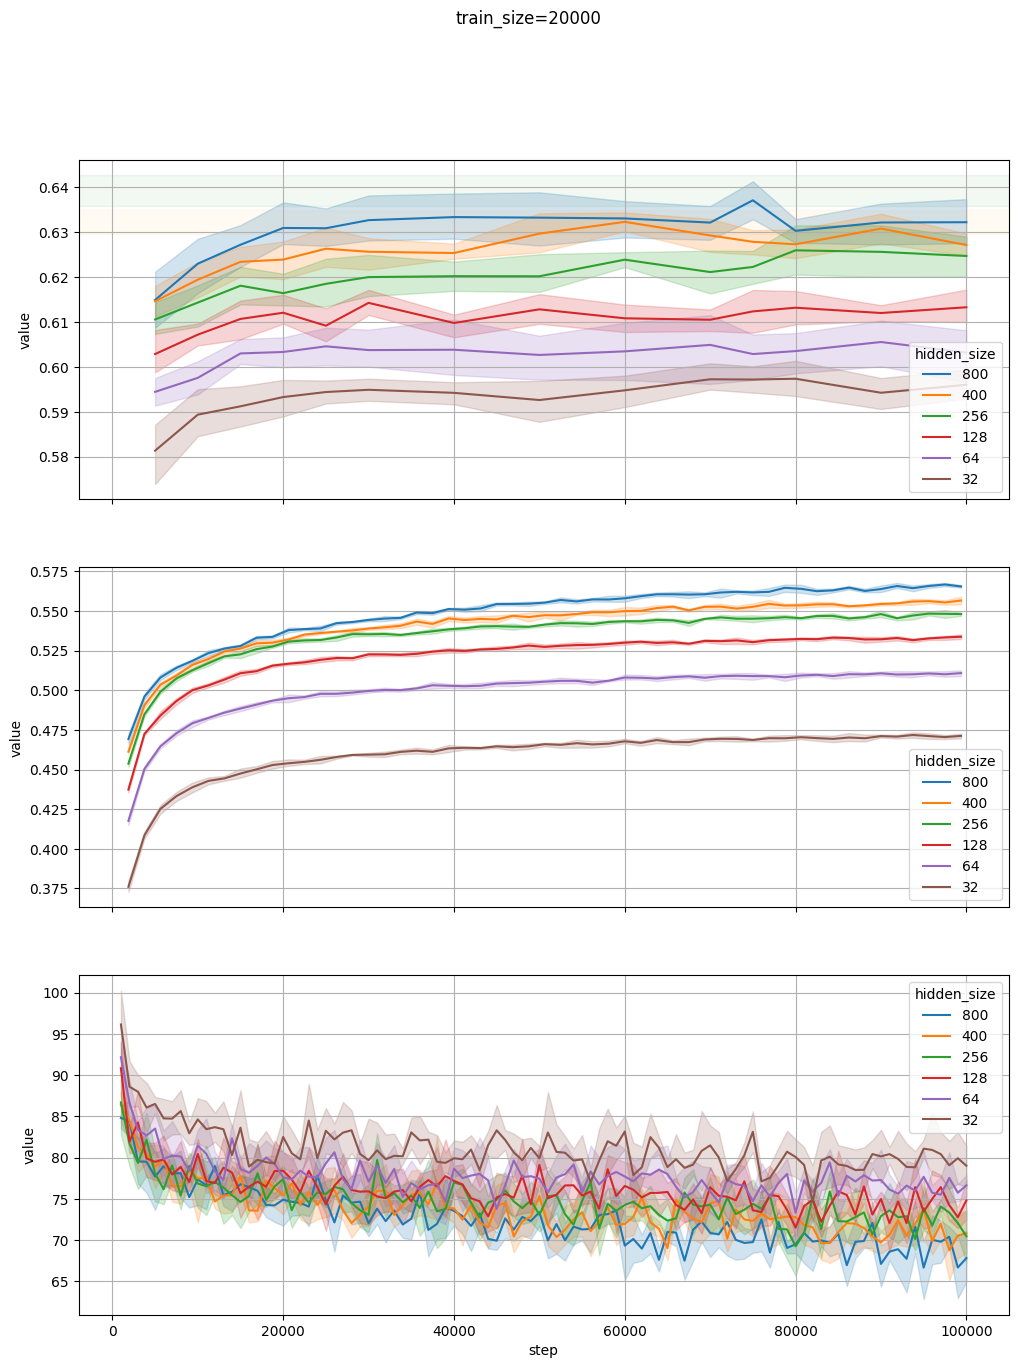

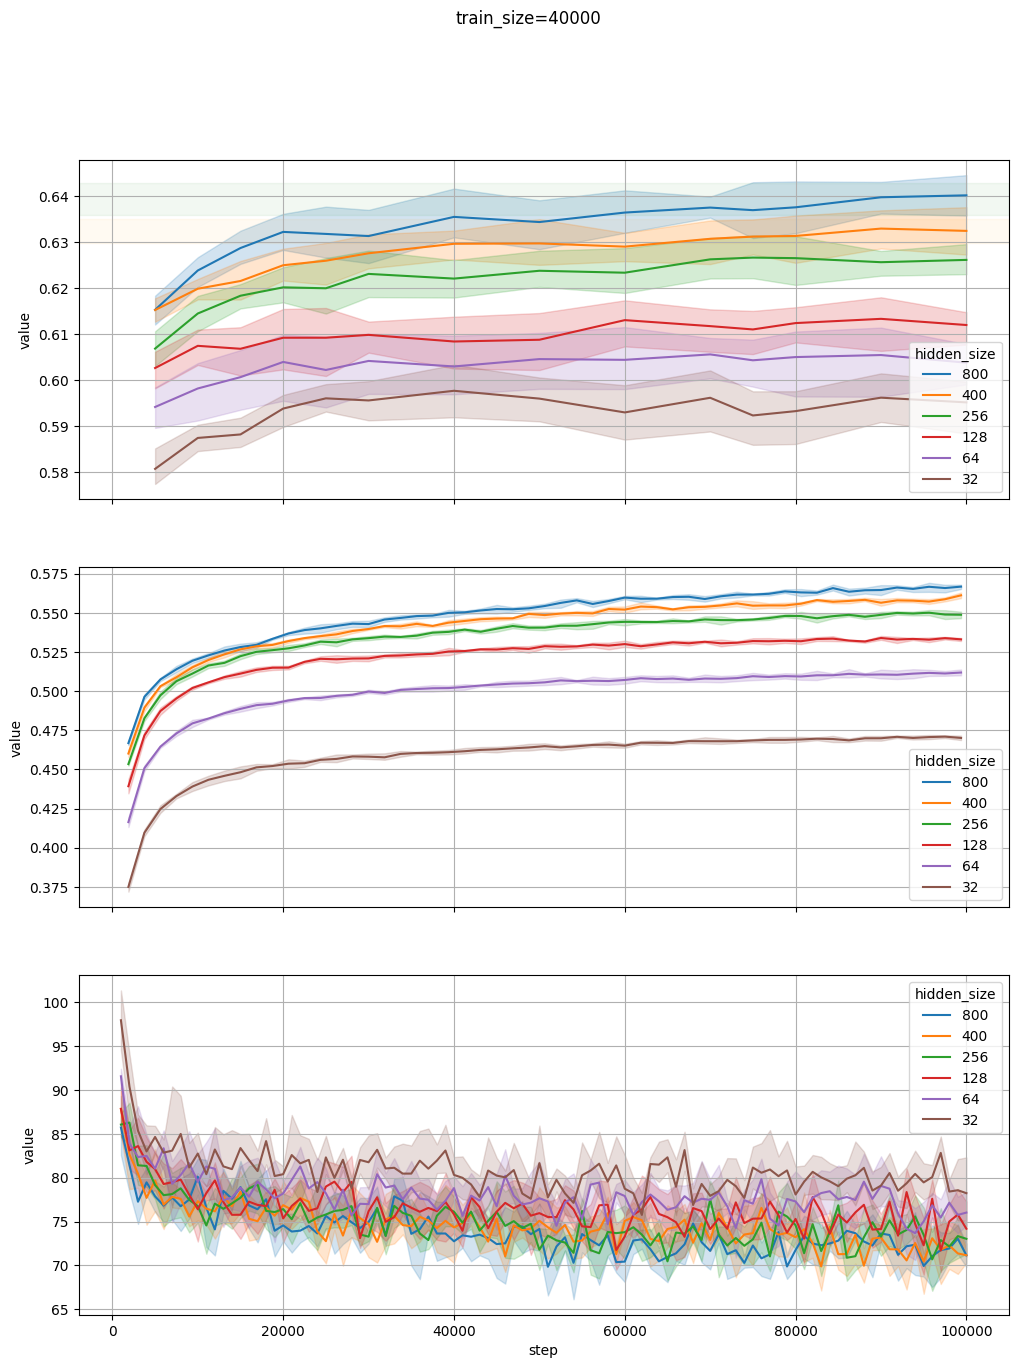

In [20]:
# df_tb = get_scalars('lightning_logs/')
# df_tb = df_tb[lambda x: 
#               x['tag'].eq('valid/recall_top_k') | 
#               x['tag'].eq('loss') & ((x['step'] + 1) % 1000 == 0)]
    
for train_size in df_res['train_size'].unique():
    _, axs = plt.subplots(3, 1, figsize=(12, 5 * 3), sharex=True)
    sns.lineplot(
        data=df_res[lambda x: x['train_size'].eq(train_size)]
        .assign(hidden_size=lambda x: x['hidden_size'].astype(str)),
        x='train_steps',
        y='value',
        hue='hidden_size',# palette=plt.get_cmap('tab10'),
        ax=axs[0],
    )
    for ax in axs[:1]:
        ax.axhspan(ymin=0.6297, ymax=0.6350, alpha=0.05, color='orange')
        ax.axhspan(ymin=0.6358, ymax=0.6427, alpha=0.05, color='green')
        # ax.axhspan(ymin=0.3845, ymax=0.3872, alpha=0.1, color='red')

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['train_size'].eq(train_size)]
            .groupby('pretrain_logger_version', as_index=False)
            [['train_size', 'hidden_size']].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'train_size', 'hidden_size']],
            df_tb[lambda x: x['tag'].eq('valid/recall_top_k')],
            on='version',
        ).assign(hidden_size=lambda x: x['hidden_size'].astype(str)),
        x='step',
        y='value',
        hue='hidden_size',# palette=plt.get_cmap('tab10'),
        ax=axs[1],
    )

    sns.lineplot(
        data=pd.merge(
        df_res[lambda x: x['train_size'].eq(train_size)]
            .groupby('pretrain_logger_version', as_index=False)
            [['train_size', 'hidden_size']].first()\
            .assign(version=lambda x: 'version_' + x['pretrain_logger_version'].astype(str))\
            [['version', 'train_size', 'hidden_size']],
            df_tb[lambda x: x['tag'].eq('loss')],  # [lambda x: (x['step'] + 1) % 1000 == 0]
            on='version',
        ).assign(hidden_size=lambda x: x['hidden_size'].astype(str)),
        x='step',
        y='value',
        hue='hidden_size',# palette=plt.get_cmap('tab10'),
        ax=axs[2],
    )
    for ax in axs:
        ax.grid()
        
    plt.suptitle(f'train_size={train_size}')
    plt.show()
